<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
پروژه ی نهایی
</font>
</h1>
<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
Feature Extraction with STDP learning
</h1>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color="orange">
  عرشیا ربیعی 
    
</font> 
</p>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color="orange">
۶۱۰۳۹۸۱۲۵ 
    
</font> 
</p>

In [1]:
from pymonntorch import *
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [2]:
settings = {'device' : 'cpu' , 'def_type' : torch.float32 }
torch.manual_seed(73)
N = 100
TIME = 500
DT = 1
TIME_WINDOW = 50
REGULAR_SPIKE = {'a' : 0.02 , 'b' : 0.2 , 'c' : -65 , 'd' : 8}
IB = {'a' : 0.02 , 'b' : 0.2 , 'c' : -55 , 'd' : 4}
CHATTERING = {'a' : 0.02 , 'b' : 0.2 , 'c' : -50 , 'd' : 2}
LOW_THRESHOLD_SPIKING = {'a' : 0.02 , 'b' : 0.25 , 'c' : -65 , 'd' : 2}
FAST_SPIKING = {'a' : 0.1 , 'b' : 0.2 , 'c' : -65 , 'd' : 2}
PARAMETER_CHOOSE = REGULAR_SPIKE
INFINITY = 1e9
POOLING_SIZE = 2
TIME_WINDOW = 50
IMAGE_SIZE = 28

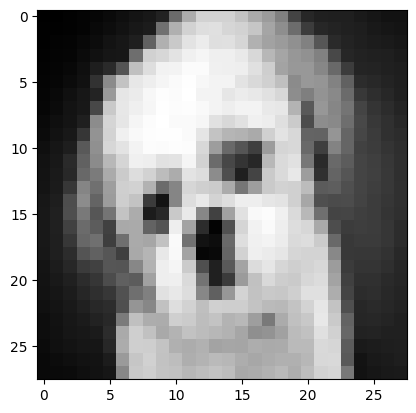

In [3]:
image = np.zeros((4 ,IMAGE_SIZE,IMAGE_SIZE))
for i in range(11, 15):
    filename = str(i) + '.png'
    img = Image.open(filename)
    img = img.convert('L')
    img = img.resize((IMAGE_SIZE,IMAGE_SIZE))
    image[i-11] = np.array(img).astype(float)
plt.imshow(image[3], cmap='gray')

In [4]:
class Ttfs:
    def __init__(self , img , time_window):
        self.img = img
        self.time_window = time_window
        self.ttfs1 = torch.zeros((self.time_window , IMAGE_SIZE , IMAGE_SIZE))
        self.img /= 255.
        self.img *= (self.time_window -1)
        self.img = self.img.astype(int)
    def _ttfs(self):
        img_copy = self.img.copy()
        i = 0
        time = 0
        while True:
            tmp_max = img_copy.max()
            if tmp_max == -1:
                break
            flat_max_index = img_copy.argmax()
            j = flat_max_index // img_copy.shape[1]
            k = flat_max_index % img_copy.shape[1]
            self.ttfs1[i][j , k] = 1
            img_copy[j,k] = -1
            if tmp_max != img_copy.max():
                i += 1
            time += 1
    def get_img_ttfs(self):
        self._ttfs()
        return self.ttfs1

In [5]:
images = torch.zeros((len(image), TIME_WINDOW , IMAGE_SIZE , IMAGE_SIZE))
for i in range(len(image)):
    ttfs = Ttfs(image[i].copy() , TIME_WINDOW)
    images[i] = ttfs.get_img_ttfs()

images.shape

torch.Size([4, 50, 28, 28])

In [11]:
images[3].sum(axis=[1,2])

tensor([ 2., 23., 17., 31., 15., 26., 21., 28., 31., 24., 21., 19., 14., 16.,
        21., 23., 10., 13., 11.,  6., 17.,  8.,  5.,  5.,  7., 17., 12.,  7.,
         9., 10., 15.,  6., 21., 20., 20., 26., 26., 27., 36., 36., 37., 20.,
        17.,  8.,  0.,  0.,  0.,  0.,  0.,  0.])

In [12]:
class Dog:
    def __init__(self , sigma1 , sigma2 , kernel_size , stride=1):
        self.s1 = sigma1
        self.s2 = sigma2
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = (self.kernel_size[0] - 1)//2
    def dog_filter(self):
        (y ,x) = np.meshgrid(np.arange(int(-self.kernel_size[0]/2) , (self.kernel_size[0])//2 + 1) , np.arange(int(-self.kernel_size[1]/2) ,(self.kernel_size[1])//2 + 1))
        xy = -0.5 * ((x**2 + y ** 2))
        return (np.exp(xy/self.s1 **2)/self.s1 - np.exp(xy/self.s2**2)/self.s2) / np.sqrt(2 * np.pi)
    def get_filt(self , oncenter):
        self.dog_filter()
        if oncenter:
            filt = self.dog_filter()
        else:
            filt = -self.dog_filter()
        return filt

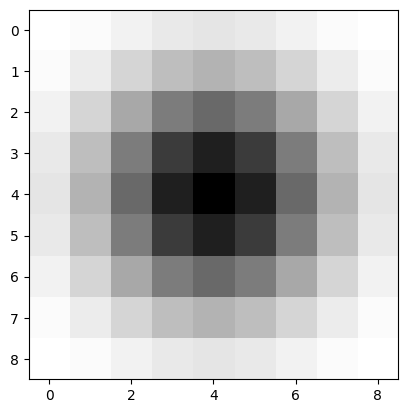

In [13]:
dog1 = Dog(2 , 5 , (9,9))
on_center = dog1.get_filt(oncenter = True)
dog2 = Dog(2 , 9 , (9,9))
off_center = dog2.get_filt(oncenter = False)
plt.imshow(off_center ,cmap='gray');

In [14]:
class Time(Behavior):
    def initialize(self,network):
        network.dt = self.parameter('dt' , DT)
        network.passed = 0
        network.time_window = self.parameter('time_window' , None , required=True)
    def forward(self , network):
        network.passed += network.dt

In [15]:
class Dendrite(Behavior):
    def initialize(self , n):
        pass
    def forward(self, n):
        n.I = n.vector(mode='zeros')
        for syn in n.afferent_synapses['GLUTAMATE']:
            n.I += syn.I

In [16]:
class InputSynapse(Behavior):
    def initialize(self,syn):
        syn.W = syn.matrix('uniform').T
#         syn.W = torch.rand(size=(syn.src.size , syn.dst.size))
#         syn.W.shape
        self.coef = self.parameter('coef' , None)
    def forward(self , syn):
        syn.I = torch.sum(syn.conv_I , axis = 0) / syn.src.size * self.coef
        
        

In [17]:
class Izhikevich_Input(Behavior):
    def initialize(self , n):
        n.pattern = self.parameter('pattern' , None , required=True)
        self.img_index = -1
        n.I = n.vector(mode='zeros')
#         n.img = n.pattern[0]
#         n.curr_pattern = n.img[0].flatten()
        self.rest_pattern = torch.zeros((28, 28))
        self.is_rest = 0
    def forward(self , n):
        mod = n.network.passed % n.network.time_window
        if mod == 0:
            self.is_rest += 1
        if self.is_rest % 2 == 1:
            if  mod == 0:
                self.img_index += 1
                n.img = n.pattern[self.img_index]
                n.curr_pattern = n.img[0].flatten()
            else:
                n.curr_pattern = n.img[mod].flatten()
            n.I[n.curr_pattern.type(torch.int64)] = 50
        else:
            n.curr_pattern = self.rest_pattern
            n.I[n.curr_pattern.type(torch.int64)] = 50

In [18]:
class Izhikevich(Behavior):
    def initialize(self , n):
        self.a = self.parameter('a' , None , required=True)
        self.b = self.parameter('b' , None , required=True)
        self.c = self.parameter('c' , None , required=True)
        self.d = self.parameter('d' , None , required=True)
        self.threshold = self.parameter('threshold' , 30)
        n.v = n.vector('uniform') * -70
        n.u = n.vector('uniform') * -15
        n.spike = n.v > self.threshold

    def _fire(self , n):
        self._spike(n)
        n.v[n.spike] = self.c
        n.u[n.spike] += self.d
    def _dv_du(self,n):
        self.dv = 0.04* (n.v**2) + 5*n.v + 140 - n.u + n.I
        self.du = self.a*(self.b * n.v - n.u)
    def _spike(self , n):
        n.spike = n.v > self.threshold
    def forward(self , n):
        self._dv_du(n)
        n.v += self.dv * n.network.dt
        n.u += self.du * n.network.dt
        self._fire(n)

In [19]:
class Flat_STDP(Behavior):
    
    def initialize(self, syn):
        self.add_tag("FlatSTDP")
        self.eta_d = self.parameter("eta_d", None)
        self.eta_p = self.parameter("eta_p", None)
        self.cte_post = self.parameter("cte_post", None)
        self.cte_pre = self.parameter("cte_pre", None)
        self.w_max = self.parameter("w_max", None)
        self.w_min = self.parameter("w_min", None)
    def softbound_ltd(self , w_max, w, eta_d):
        return (w_max - w) * eta_d

    def softbound_ltp(self , w_min, w, eta_p):
        return (w - w_min) * eta_p  
    def _dw(self, syn):
        A_plus = self.softbound_ltd(self.w_max, syn.W, self.eta_d)
        A_minus = self.softbound_ltp(self.w_min, syn.W, self.eta_p)
        time_stdp_src = syn.src.local >= 0.
        time_stdp_dst = syn.dst.local >= 0.
        dw_LTD = torch.outer(time_stdp_src * self.cte_pre, syn.dst.spike) * A_plus
        dw_LTP = torch.outer(syn.src.spike, time_stdp_dst * self.cte_post) * A_minus
        syn.dw = dw_LTD - dw_LTP
        return syn.dw
        
    def forward(self, syn):
#         a = self._dw(syn)
#         syn.W += a
#         print(a)
        syn.W += self._dw(syn)


In [20]:
class Local_variables(Behavior):
    
    def initialize(self, syn):
        self.tau = self.parameter("tau", None , required=True)
        syn.src.local = syn.src.vector(mode="zeros")
        syn.dst.local = syn.dst.vector(mode="zeros")
    def forward(self, syn):
        d_local_src = -1 * syn.src.local/self.tau + syn.src.spike
        d_local_dst = -1 * syn.dst.local/self.tau + syn.dst.spike

        syn.src.local += d_local_src
        syn.dst.local += d_local_dst

In [21]:
class Convolution(Behavior):
    def initialize(self , syn):
        self.filter1 = self.parameter('filter1' , None , required=True)
        self.filter2 = self.parameter('filter2' , None , required=True)
        self.r = self.parameter('r' , None ,required=True)
        self.kernel_size = (self.filter1.shape[0] , self.filter1.shape[1])
        self.stride = self.parameter('stride' , 1 , required=True)
        self.pad = (self.kernel_size[0] - 1)//2
    def _convolt(self , img , filt):
#         plt.imshow(filt ,cmap='gray');
        result = torch.zeros(img.shape)
        pad_img = np.pad(img , pad_width=self.pad)
        
        for i in range(0 , len(pad_img) - self.kernel_size[0]+1 , self.stride):
            for j in range(0 , len(pad_img) - self.kernel_size[1]+1 , self.stride):
                result[i , j] = np.sum( (pad_img[i: i + self.kernel_size[0], j : j + self.kernel_size[1]]) * filt)
        if result.min() != result.max() and result.max() == 0:
            result -= result.min()
            result /= result.max()
#         result *= 255

        return result
    def forward(self , syn):
        syn.curr_ttfs = syn.src.curr_pattern.reshape(IMAGE_SIZE , IMAGE_SIZE)
        syn.dst.feature1 = self._convolt(syn.curr_ttfs , self.filter1)
        syn.dst.feature1 -= syn.dst.feature1.min()
        syn.dst.feature1 /= syn.dst.feature1.max()
        syn.dst.feature2 = self._convolt(syn.curr_ttfs , self.filter2)
        syn.dst.feature2 -= syn.dst.feature2.min()
        syn.dst.feature2 /= syn.dst.feature2.max()
        syn.conv_I = syn.dst.feature1.flatten()
        syn.conv_I += syn.dst.feature2.flatten()
        
        syn.conv_I *= self.r

In [22]:
class Max_Pooling(Behavior):
    def initialize(self , syn):
        self.pooling_size = self.parameter('size' , 2 ,required=False)
        self.stride = self.parameter('stride' , self.pooling_size ,required=False)
        self.r = self.parameter('r' , None ,required=True)
    def pooling(self,syn,feature):
        pool = torch.zeros((feature.shape[0] // self.pooling_size , feature.shape[1] // self.pooling_size))
        for i in range(0 , pool.shape[0] , self.stride):
            for j in range(0 , pool.shape[1] , self.stride):
                pool[i//self.stride , j//self.stride] = feature[i: i+self.stride , j : j+self.stride].max()
#         syn.I = pool * self.r
        return pool
    def forward(self , syn):
        syn.dst.feature1 = self.pooling(syn , syn.src.feature1)
        syn.dst.feature1 -= syn.dst.feature1.min()
        syn.dst.feature1 /= syn.dst.feature1.max()
        syn.dst.feature2 = self.pooling(syn , syn.src.feature2)
        syn.dst.feature2 -= syn.dst.feature2.min()
        syn.dst.feature2 /= syn.dst.feature2.max()
        syn.conv_I = syn.dst.feature1.flatten()
        syn.conv_I *= self.r

In [23]:
images.shape

torch.Size([4, 50, 28, 28])

In [31]:
net = Network(settings=settings , behavior={
    19 : Time(dt = 1 , time_window = TIME_WINDOW)
})

In [32]:
exc_pop1 = NeuronGroup(tag = 'EXC1' , size = images.shape[2] * images.shape[3] , net=net , behavior={
    2 : Izhikevich_Input(pattern = images),
    3 : Izhikevich(**PARAMETER_CHOOSE)
    
})

In [33]:
exc_pop2 = NeuronGroup(tag = 'EXC2' , size = images.shape[2]*images.shape[3] , net=net , behavior={
    9 : Dendrite(),
    10 : Izhikevich(**PARAMETER_CHOOSE)
})

In [34]:
exc_pop3 = NeuronGroup(tag = 'EXC3' , size = images.shape[2]//POOLING_SIZE * images.shape[3]//POOLING_SIZE , net=net , behavior={
    13 : Dendrite(),
    14 : Izhikevich(**PARAMETER_CHOOSE)
    
})

In [35]:
syn1 = SynapseGroup(net = net , tag = 'GLUTAMATE' , src= exc_pop1 , dst=exc_pop2 , behavior={
    4 : Convolution(filter1 = on_center , filter2 = off_center, r = 80 , stride = 2),
    6 : InputSynapse(coef = 1),
    7 : Local_variables(tau = 10.),
    8 : Flat_STDP(eta_d=0.410, eta_p=0.401, cte_post=0.025, cte_pre=0.015, w_max=1, w_min=0),
    
    20 : Recorder(['s.W']),
})
syn2 = SynapseGroup(net = net , tag = 'GLUTAMATE' , src= exc_pop2 , dst=exc_pop3 , behavior={
    11 : Max_Pooling(size = 2, r = 80 , stride = 2),
    12 : InputSynapse(coef = 1),
    20: Recorder(['s.W']),
})

In [36]:
net.initialize()
net.simulate_iterations(TIME_WINDOW * images.shape[0] * 2)

Network['Network'](Neurons: tensor(1764)|3 groups, Synapses: tensor(768320)|2 groups){19:Time(dt=1,time_window=50,)}
NeuronGroup['EXC1', 'NeuronGroup', 'ng'](784){2:Izhikevich_Input(pattern=tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

   

400xBatch: 1/1 (100%) 101103.483ms


101103.48296165466

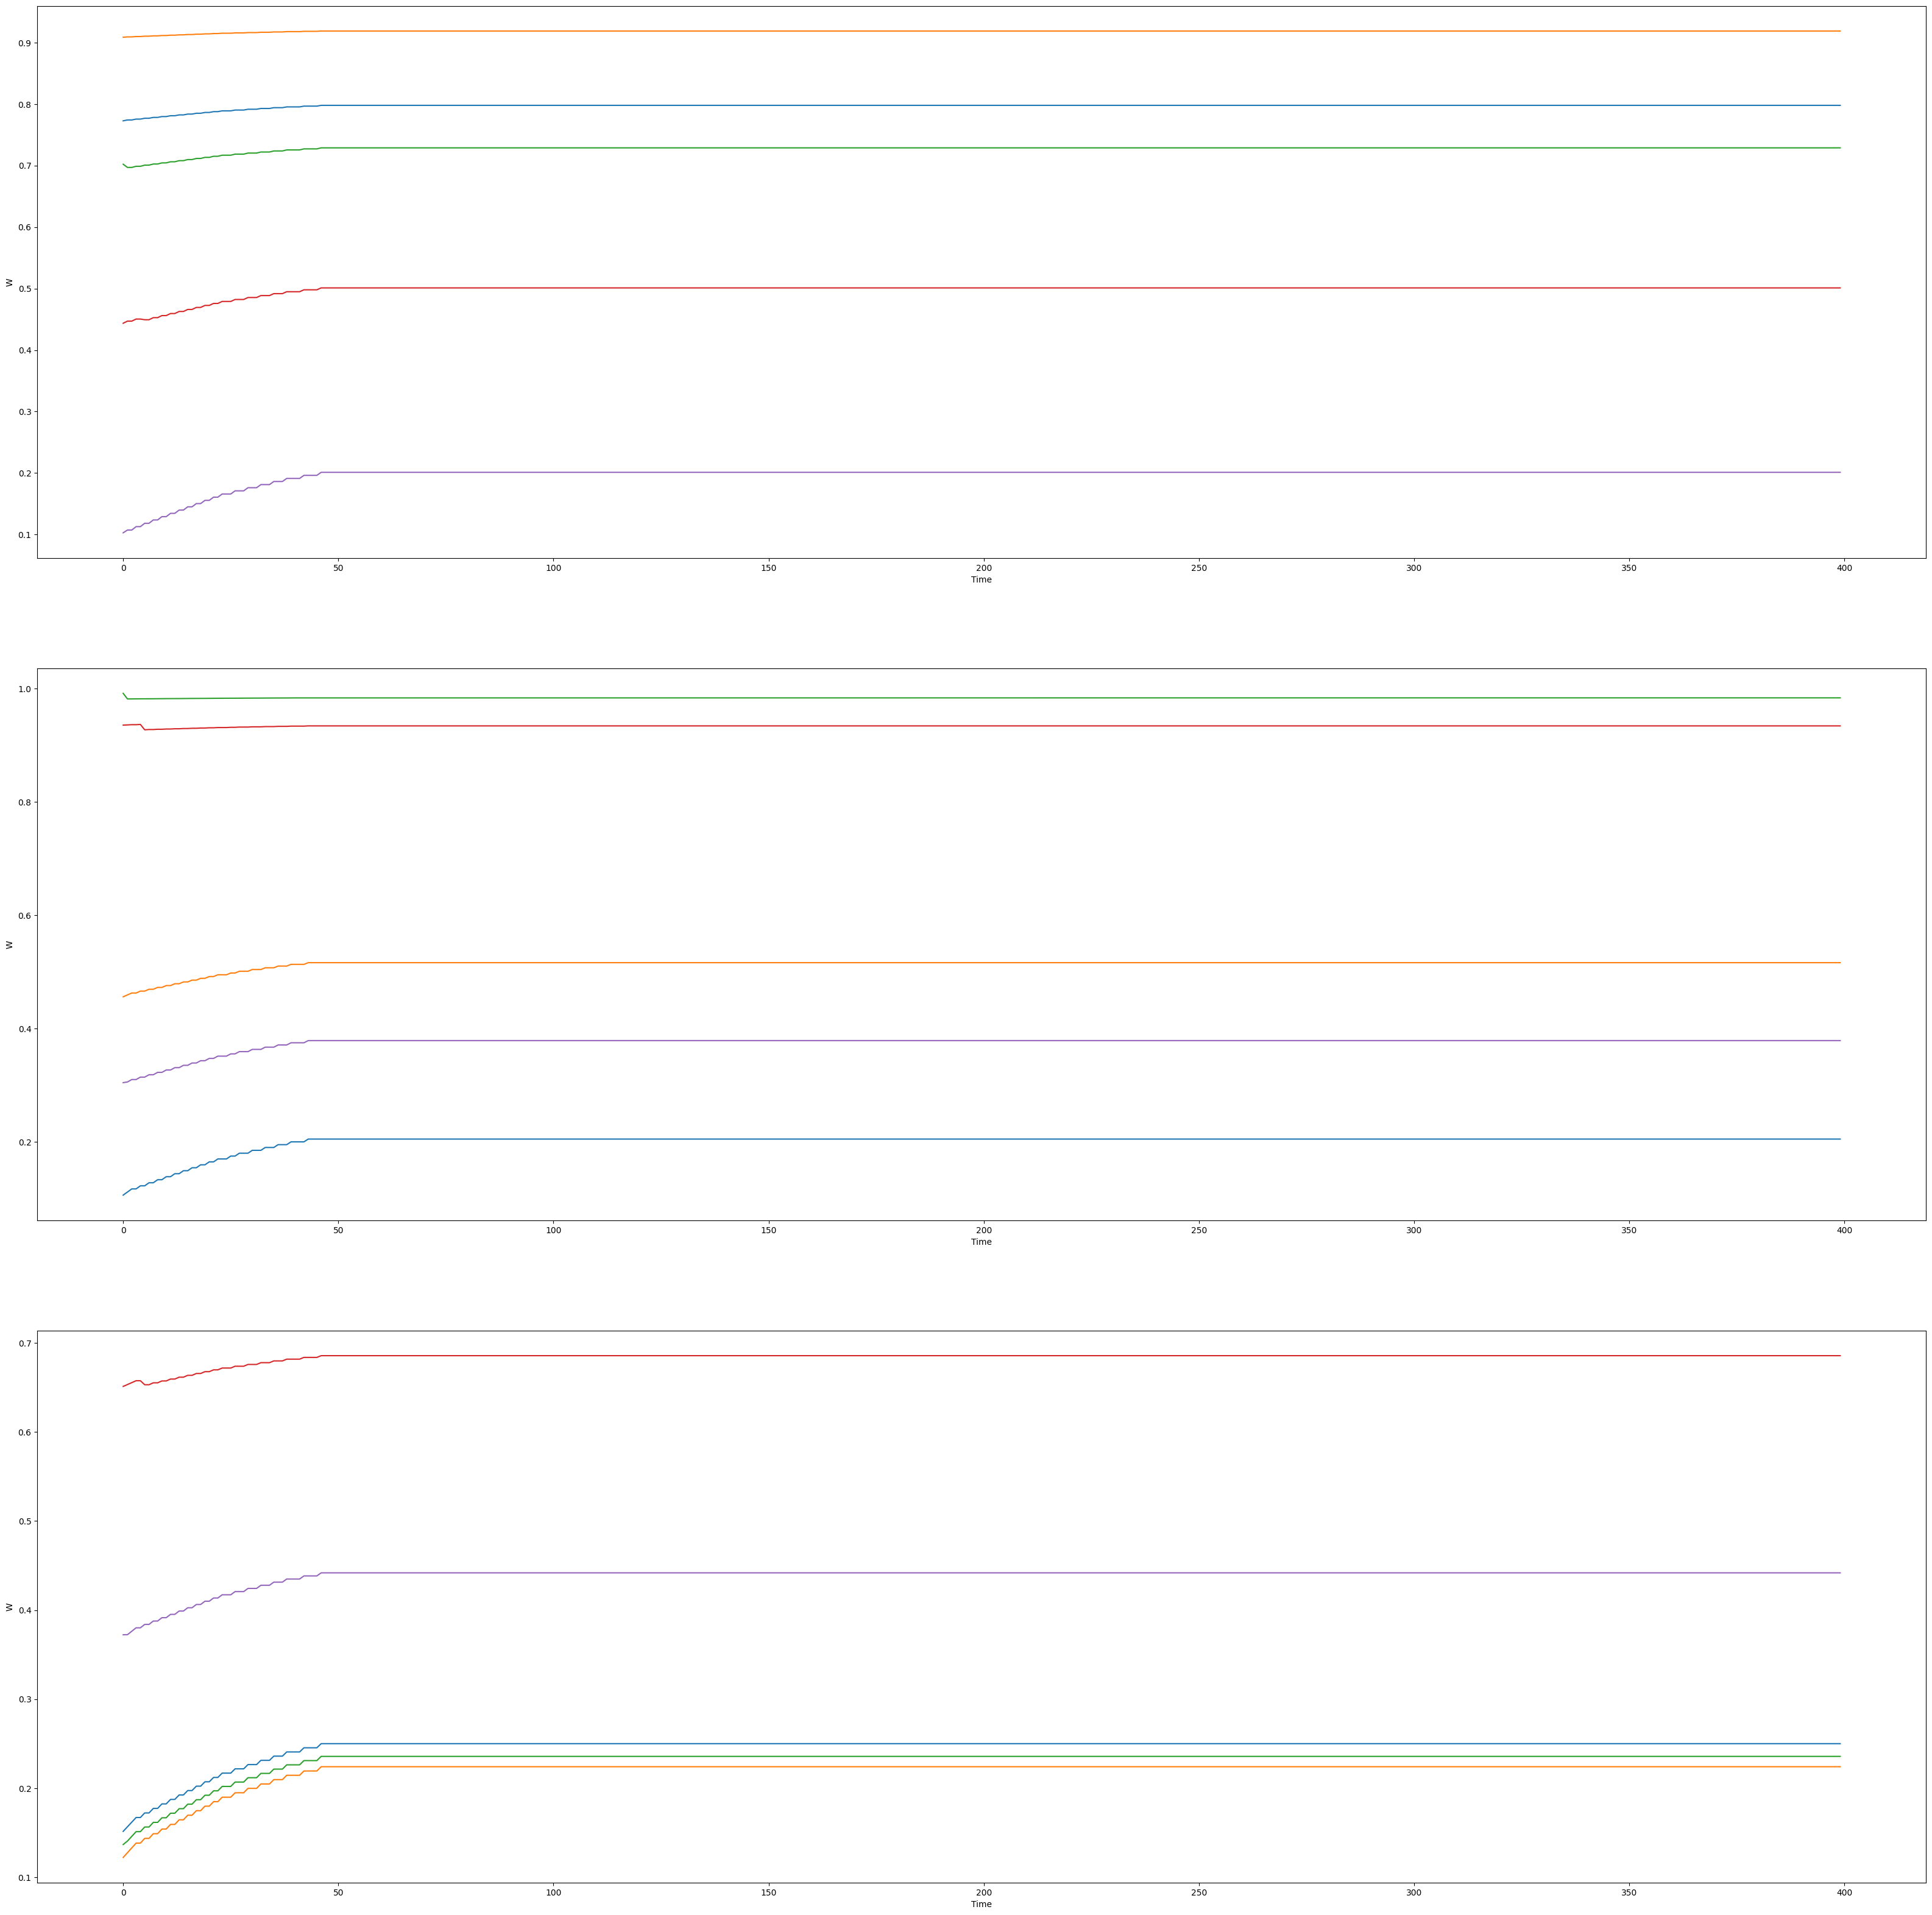

In [30]:
fig, axs = plt.subplots(3, figsize=(40,40))
time = np.arange(0, 400, 1)

for i in range(3):
    for j in range(10 , 15):
        w = syn1['s.W', 0][:, j, i]
        axs[i].plot(time, w)
        axs[i].set(xlabel="Time", ylabel="W")
plt.show()